In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from funcs import mean_median, mm_sample, survey, nearest_wavelength, mass_sample
from importlib import reload  
from tqdm import tqdm
filesave=1
import warnings
warnings.filterwarnings('ignore')
import pickle
runall=0

# Get all the data in

In [4]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='extrapolate'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)
area_dict={'JADES Deep':46./3600/tot_sky, 
           'JADES Medium':190./3600/tot_sky, 
           'JADES Deep Extended':190./3600/tot_sky, 
           'JADES Medium Extended':5*190./3600/tot_sky,
           '1 pointing':  2*4.84/3600/tot_sky, 
           '20 pointings':  20*2*4.84/3600/tot_sky, 
           '100 pointings':  2*4.84/3600*100/tot_sky, 
           '1000 pointings':  2*4.84/3600*1000/tot_sky,
          'JADES Deep Superextended': 5*190/3600/tot_sky,
          'COSMOS':2/tot_sky,
          'COSMOS2':4/tot_sky}
# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
df = pandas.read_csv(path+'cv_one_pointing.csv')
z_vals = df["z"].values
z_vals = z_vals[::-1]

In [4]:
if filesave:
    surveys={}
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    meansdeep, sigdeep = mean_median(deep)
    surveys['JADES Deep']=meansdeep, sigdeep

    wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    meanswide, sigwide = mean_median(wide)
    surveys['JADES Medium']=meanswide, sigwide

    deepE = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
    meansdeepE, sigdeepE = mean_median(deepE)
    surveys['JADES Deep Extended']=meansdeepE, sigdeepE

    wideE = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
    meanswideE, sigwideE = mean_median(wideE)
    surveys['JADES Medium Extended']=meanswideE, sigwideE

    parallel_1 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    means1, sig1 = mean_median(parallel_1)
    surveys['1 pointing']=means1, sig1

    parallel_20 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    means20, sig20 = mean_median(parallel_20)
    surveys['20 pointings']=means20, sig20

    parallel_100 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    means100, sig100 = mean_median(parallel_100)
    surveys['100 pointings']=means100, sig100

    parallel_1000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    means1000, sig1000 = mean_median(parallel_1000)
    surveys['1000 pointings']=means1000, sig1000
    output = open('data/'+file+'_means.pkl', 'wb')
    pickle.dump(surveys, output)
    output.close()
if not filesave:
    # read dict back from the file
    pkl_file = open('data/'+file+'_means.pkl', 'rb')
    surveys = pickle.load(pkl_file)
    pkl_file.close()

In [5]:
if filesave:
    masssurveys={}
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    meansdeep, sigdeep, massdeep = mass_sample(deep)
    masssurveys['JADES Deep']=meansdeep, sigdeep, massdeep

    wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    meanswide, sigwide, masswide = mass_sample(wide)
    masssurveys['JADES Medium']=meanswide, sigwide, masswide

    deepE = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
    meansdeepE, sigdeepE, massdeepE = mass_sample(deepE)
    masssurveys['JADES Deep Extended']=meansdeepE, sigdeepE, massdeepE

    wideE = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
    meanswideE, sigwideE, masswideE = mass_sample(wideE)
    masssurveys['JADES Medium Extended']=meanswideE, sigwideE, masswideE

    parallel_1 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    means1, sig1, mass1 = mass_sample(parallel_1)
    masssurveys['1 pointing']=means1, sig1, mass1

    parallel_20 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    means20, sig20, mass20 = mass_sample(parallel_20)
    masssurveys['20 pointings']=means20, sig20, mass20

    parallel_100 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    means100, sig100, mass100 = mass_sample(parallel_100)
    masssurveys['100 pointings']=means100, sig100, mass100

    parallel_1000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    means1000, sig1000, mass1000 = mass_sample(parallel_1000)
    masssurveys['1000 pointings']=means1000, sig1000, mass1000
    output = open('data/'+file+'mass_means.pkl', 'wb')
    pickle.dump(masssurveys, output)
    output.close()
if not filesave:
    # read dict back from the file
    pkl_file = open('data/'+file+'mass_means.pkl', 'rb')
    masssurveys = pickle.load(pkl_file)
    pkl_file.close()

In [7]:
if runall:
    if filesave:
        surveys={}
        deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
        meansdeep, meddeep, z_vals=mm_sample(deep)
        surveys['JADES Deep']=meansdeep, meddeep

        wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
        meanswide, medwide, z_vals=mm_sample(wide)
        surveys['JADES Medium']=meanswide, medwide

        deepE = survey(30.7, 190./3600, "cv_jades_deep_extend.csv", nearest_wavelength(x,14873.4))
        meansdeepE, meddeepE, z_vals=mm_sample(deepE)
        surveys['JADES Deep Extended']=meansdeepE, meddeepE

        wideE = survey(29.8, 5*190./3600, "cv_jades_medium_extend.csv", nearest_wavelength(x,14873.4))
        meanswideE, medwideE, z_vals=mm_sample(wideE)
        surveys['JADES Medium Extended']=meanswideE, medwideE

        parallel_1 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
        means1, med1, z_vals=mm_sample(parallel_1)
        surveys['1 pointing']=means1, med1

        parallel_20 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
        means20, med20, z_vals=mm_sample(parallel_20)
        surveys['20 pointings']=means20, med20

        parallel_100 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
        means100, med100, z_vals=mm_sample(parallel_100)
        surveys['100 pointings']=means100, med100

        parallel_1000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
        means1000, med1000, z_vals=mm_sample(parallel_1000)
        surveys['1000 pointings']=means1000, med1000
        output = open('data/'+file+'_meanmedsamp.pkl', 'wb')
        pickle.dump(surveys, output)
        output.close()
    if not filesave:
        # read dict back from the file
        pkl_file = open('data/'+file+'_meanmedsamp.pkl', 'rb')
        meanmedsample = pickle.load(pkl_file)
        pkl_file.close()

In [8]:
def ms_plot(sur, k, mean, sig, newmass, ax=None, legend=True, c='r',start=1, norm=150, save=False, i=0, scale='log', top=None, bottom=1e-7):
    mass=newmass[start:]
    h=cosmo.H0.value/100
    dz=[z_vals[k+1]-z_vals[k],z_vals[k]-z_vals[k-1]]
    norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur]
    norm=norm*h**3
    errcv=sig*mean
    errtot=np.sqrt(mean+(errcv)**2)
    poiserr=np.sqrt(mean)
    errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
    if ax==None:
        fig, ax=plt.subplots(figsize=(12,9))
    else:
        s=0
        
    if i==0:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1,
                    label='Total statistical uncertainty')
    else:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4)
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2)
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1)
    if legend:
        ax.yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for different survey designs', yscale=scale)
        ax.set_ylim(bottom, top)
        ax.legend(fontsize=10, loc='upper left')
    if save:
        plt.savefig(f'figs/masslumfunc/z_{np.round(z_vals[k],1)}_total.png')

In [12]:
def sample_plot(sur, ks, mean1, sig, newmass, ax=None, legend=True, c='r',start=20, stop=-1, save=False, i=0, scale='log', top=None, bottom=1e-7):    
    fig, ax=plt.subplots(figsize=(15,15), nrows=3, ncols=2)
    mass=newmass
    h=cosmo.H0.value/100
    i=0
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][0].plot(mass[start:stop], mean[k][start:stop], c, label=f'mass function for {sur}')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][0].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][0].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for {sur}', yscale=scale)
        ax[i][0].set_ylim(bottom, top)
        ax[i][0].legend(fontsize=10, loc='lower left')
        
        ax[i][1].plot(mass[start:stop], rel[start:stop], c, label=f'mass function for {sur}')
        i+=1
    fig.tight_layout()
    if save:
        plt.savefig(f'figs/masslumfunc/z_{np.round(z_vals[k],1)}_total.png')

In [96]:
def compare_plot(sur1, sur2, datadict, ks, legend=True, c='r', c2='b', start=20, stop=-1, save=False, i=0, scale='log', top=None, bottom=1e-7):    
    fig, ax=plt.subplots(figsize=(15,15), nrows=3, ncols=2)
    h=cosmo.h
    i=0
    mean1, sig, mass=1.1*datadict[sur1][0], datadict[sur1][1], datadict[sur1][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur1]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][0].plot(mass[start:stop], mean[k][start:stop], c, label=f'Mass function for {sur1}')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][0].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][0].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        ax[i][0].set_ylim(bottom, top)
        ax[i][0].legend(fontsize=10, loc='upper right')
        i+=1
    i=0
    mean1, sig, mass=1.1*datadict[sur2][0], datadict[sur2][1], datadict[sur2][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur2]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        ax[i][1].plot(mass[start:stop], mean[k][start:stop], c2, label=f'Mass function for {sur2}')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c2, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c2, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c2, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][1].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][1].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for {sur2}', yscale=scale)
        ax[i][1].set_ylim(bottom, top)
        ax[i][1].legend(fontsize=10, loc='upper right')
        i+=1
    fig.tight_layout()
    if save:
        plt.savefig(f'figs/masslumfunc/compare_{sur1} and {sur2}z_{np.round(z_vals[k],1)}_total.png')

In [136]:
def compare_pretty(sur1, sur2, datadict, ks, legend=True, c='r', c2='b', start=20, stop=-1, save=False, i=0, scale='log', top=None, bottom=1e-7):    
    fig, ax=plt.subplots(figsize=(15,15), nrows=3, ncols=2)
    h=cosmo.h
    i=0
    mean1, sig, mass=1.1*datadict[sur1][0], datadict[sur1][1], datadict[sur1][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur1]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][0].plot(mass[start:stop], mean[k][start:stop], c, label=f'Mass function for {sur1}')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][0].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        if i==2:
            ax[i][0].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
                   title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        else:
            ax[i][0].set(ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
                   title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        ax[i][0].set_ylim(bottom, top)
        ax[i][0].legend(fontsize=11.5, loc='upper right')
        i+=1
    i=0
    mean1, sig, mass=1.1*datadict[sur2][0], datadict[sur2][1], datadict[sur2][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur2]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        ax[i][1].plot(mass[start:stop], mean[k][start:stop], c2, label=f'Mass function for {sur2}')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c2, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c2, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c2, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][1].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        if i==2:
            ax[i][1].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]',\
                   title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        else:
            ax[i][1].set(title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        ax[i][1].set_ylim(bottom, top)
        ax[i][1].legend(fontsize=12, loc='upper right')
        i+=1
    fig.tight_layout()
    if save:
        plt.savefig(f'figs/masslumfunc/compare_{sur1} and {sur2}z_{np.round(z_vals[k],1)}_total.png')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


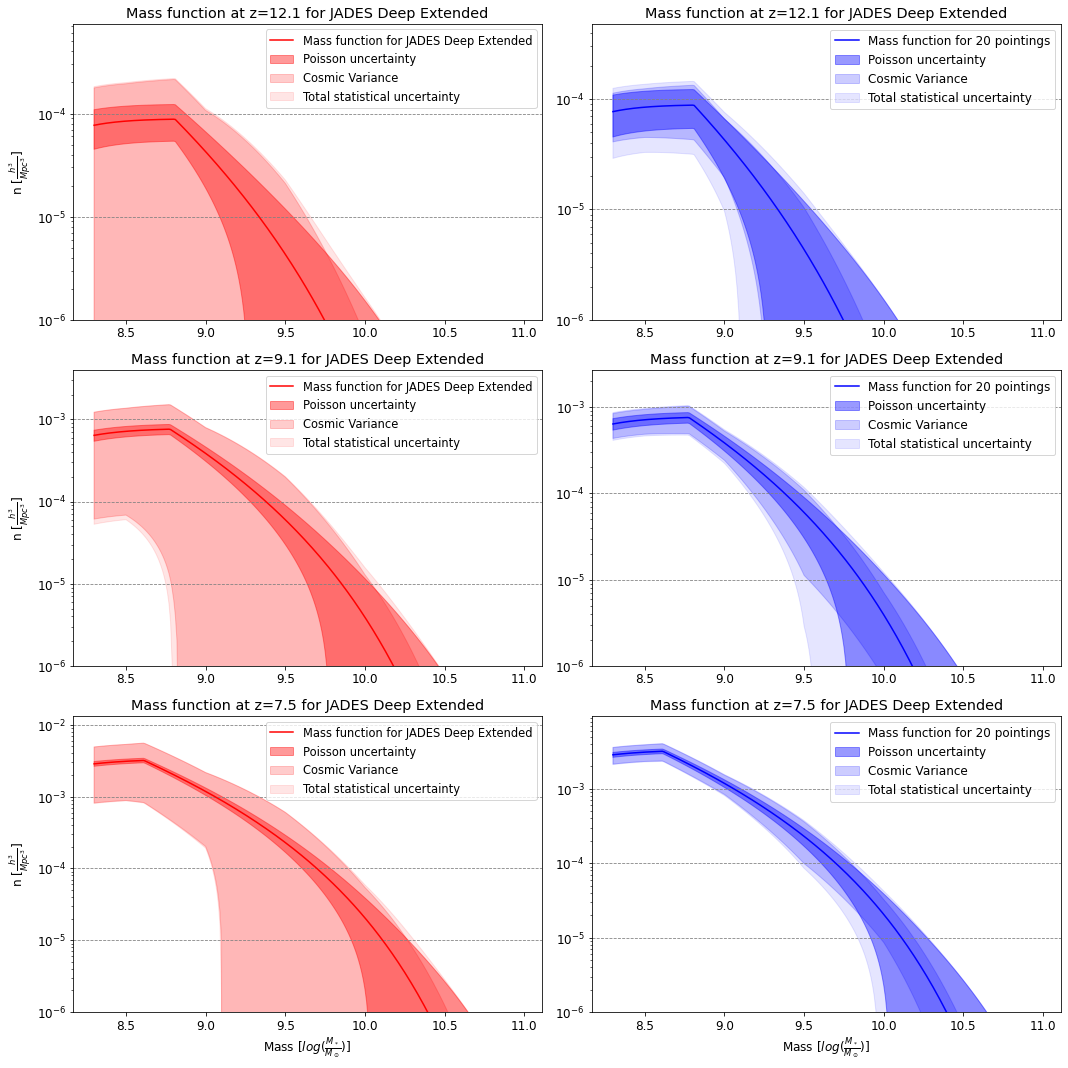

In [137]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
compare_pretty('JADES Deep Extended', '20 pointings', masssurveys, [8,12,15],start=30,stop=-1,save=1, top=None, bottom=1e-6)

In [26]:
# import funcs
# reload(funcs)
# mass_sample=funcs.mass_sample

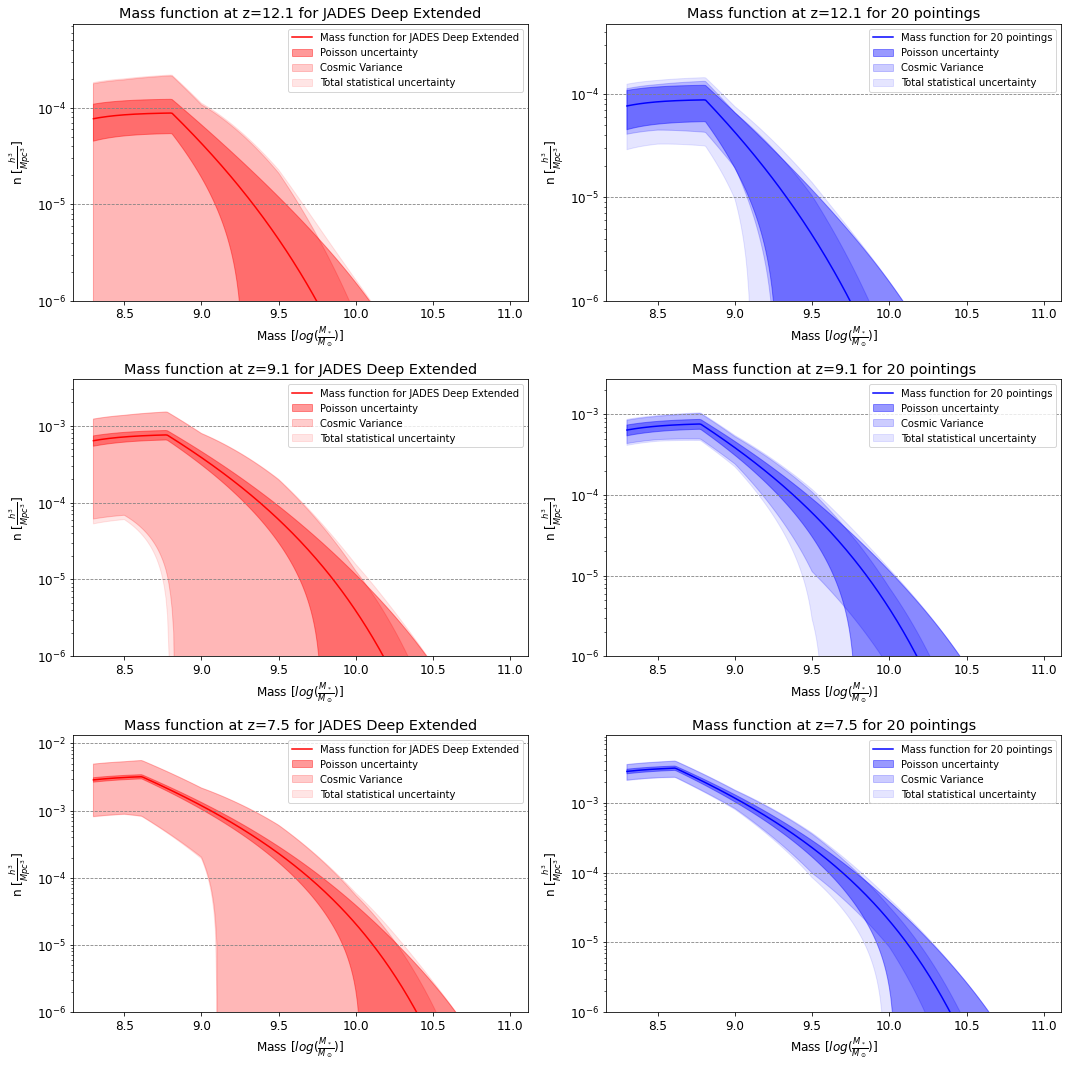

In [140]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
compare_plot('JADES Deep Extended', '20 pointings', masssurveys, [8,12,15],start=30,stop=-1,save=1, top=None, bottom=1e-6)

In [93]:
def compare_plot_nonorm(sur1, sur2, datadict, ks, legend=True, c='r', c2='b', start=20, stop=-1, save=False, i=0, scale='log', top=None, bottom=1e-7):    
    fig, ax=plt.subplots(figsize=(15,15), nrows=3, ncols=2)
    h=cosmo.h
    i=0
    mean1, sig, mass=1.1*datadict[sur1][0], datadict[sur1][1], datadict[sur1][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
#         print(norm)
        norm=1
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][0].plot(mass[start:stop], mean[k][start:stop], c, label=f'Mass function for {sur1}')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][0].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][0].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][0].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'N',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale)
        ax[i][0].set_ylim(bottom, top)
        ax[i][0].legend(fontsize=10, loc='upper right')
        i+=1
    i=0
    mean1, sig, mass=1.1*datadict[sur2][0], datadict[sur2][1], datadict[sur2][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=1
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][1].plot(mass[start:stop], mean[k][start:stop], c2, label=f'Mass function for {sur2}')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c2, alpha=0.4,
                    label='Poisson uncertainty')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c2, alpha=0.2,
                    label='Cosmic Variance')
        ax[i][1].fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c2, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][1].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][1].set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'N',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for {sur2}', yscale=scale)
        ax[i][1].set_ylim(bottom, top)
        ax[i][1].legend(fontsize=10, loc='upper right')
        i+=1
    fig.tight_layout()
    if save:
        plt.savefig(f'figs/masslumfunc/compare_{sur1} and {sur2}z_{np.round(z_vals[k],1)}_total.png')

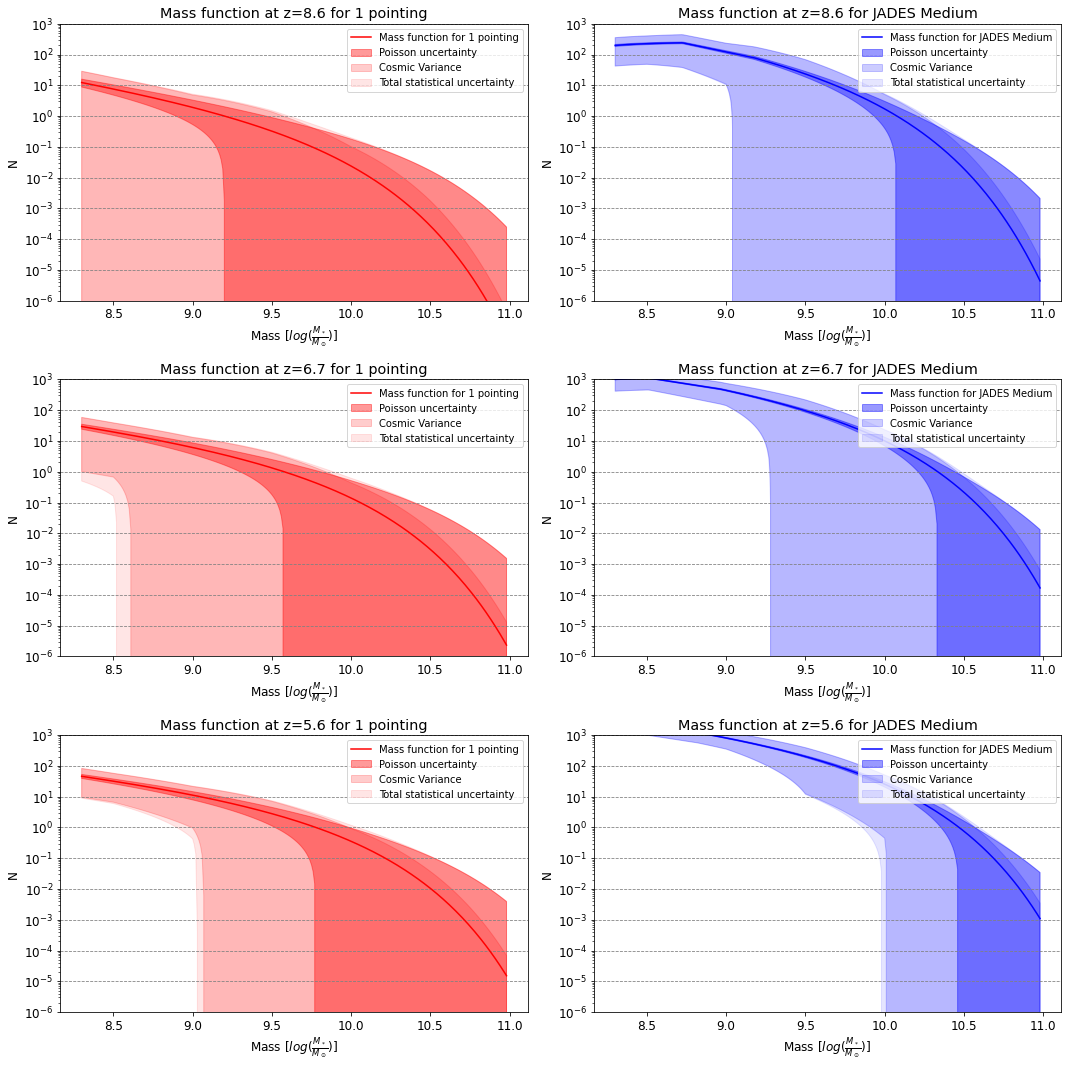

In [139]:
compare_plot_nonorm('1 pointing', 'JADES Medium', masssurveys, [13,17,20],start=30,stop=-1,save=0, top=1000, bottom=1e-6)

In [20]:
def LF_center(M, z):
    Ms = -20.95 + 0.01 * (z - 6)
    p = 0.47 * 10**(-0.27 * (z - 6)) * 10**(-3)
    a = -1.87 - 0.1 * (z - 6)
    LF = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))
    return LF

def compare_lumfunc(sur1, sur2, datadict, ks, legend=True, c='r', c2='b', right=1e8, left=1e10, start=20, stop=-1, save=False, i=0, scale='log', top=None, bottom=1e-7):
    fig, ax=plt.subplots(figsize=(15,15), nrows=3, ncols=2)
    h=cosmo.h
    i=0
    mean1, sig, mass=1.1*datadict[sur1][0], datadict[sur1][1], datadict[sur1][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur2]
        norm=norm*h**3
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        lums=LF_center(mass, z_vals[k])
        ax[i][0].plot(lums[start:stop], mean[k][start:stop], c, label=f'Mass function for {sur1}')
        ax[i][0].fill_between(lums[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.4,
                    label='Cosmic Variance')
        ax[i][0].fill_between(lums[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.2,
                    label='Poisson uncertainty')
        ax[i][0].fill_between(lums[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][0].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][0].set(xlabel=r'Luminosity [$log(\frac{L_*}{L_\odot})$]', ylabel=r'N',\
               title=f'Luminosity function at z={np.round(z_vals[k],1)} for {sur1}', yscale=scale, xscale='log')
        ax[i][0].set_ylim(bottom, top)
#         ax[i][0].set_ylim(left, right)
        ax[i][0].legend(fontsize=10, loc='upper right')
        i+=1
    i=0
    mean1, sig, mass=1.1*datadict[sur2][0], datadict[sur2][1], datadict[sur2][2]
    for k in ks:
        mean=mean1
        dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
        norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur2]
        norm=norm*h**3
        norm=1
        errcv=sig*mean
        errtot=np.sqrt(mean+(errcv)**2)
        poiserr=np.sqrt(mean)
        errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
        lums=LF_center(mass, z_vals[k])
        rel=errcv[k]**2/poiserr[k]**2
        ax[i][1].plot(lums[start:stop], mean[k][start:stop], c2, label=f'Luminosity function for {sur2}')
        ax[i][1].fill_between(lums[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c2, alpha=0.4,
                    label='Cosmic Variance')
        ax[i][1].fill_between(lums[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c2, alpha=0.2,
                    label='Poisson uncertainty')
        ax[i][1].fill_between(lums[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c2, alpha=0.1,
                    label='Total statistical uncertainty')

        ax[i][1].yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax[i][1].set(xlabel=r'Luminosity [$log(\frac{L_*}{L_\odot})$]', ylabel=r'N',\
               title=f'Luminosity function at z={np.round(z_vals[k],1)} for {sur2}', yscale=scale, xscale='log')
        ax[i][1].set_ylim(bottom, top)
#         ax[i][1].set_xlim(right, left)
        ax[i][1].legend(fontsize=10, loc='upper right')
        i+=1
    fig.tight_layout()
    if save:
        plt.savefig(f'figs/masslumfunc/compare_{sur1} and {sur2}z_{np.round(z_vals[k],1)}_total.png')
    return lums[start:stop], mean[k][start:stop]

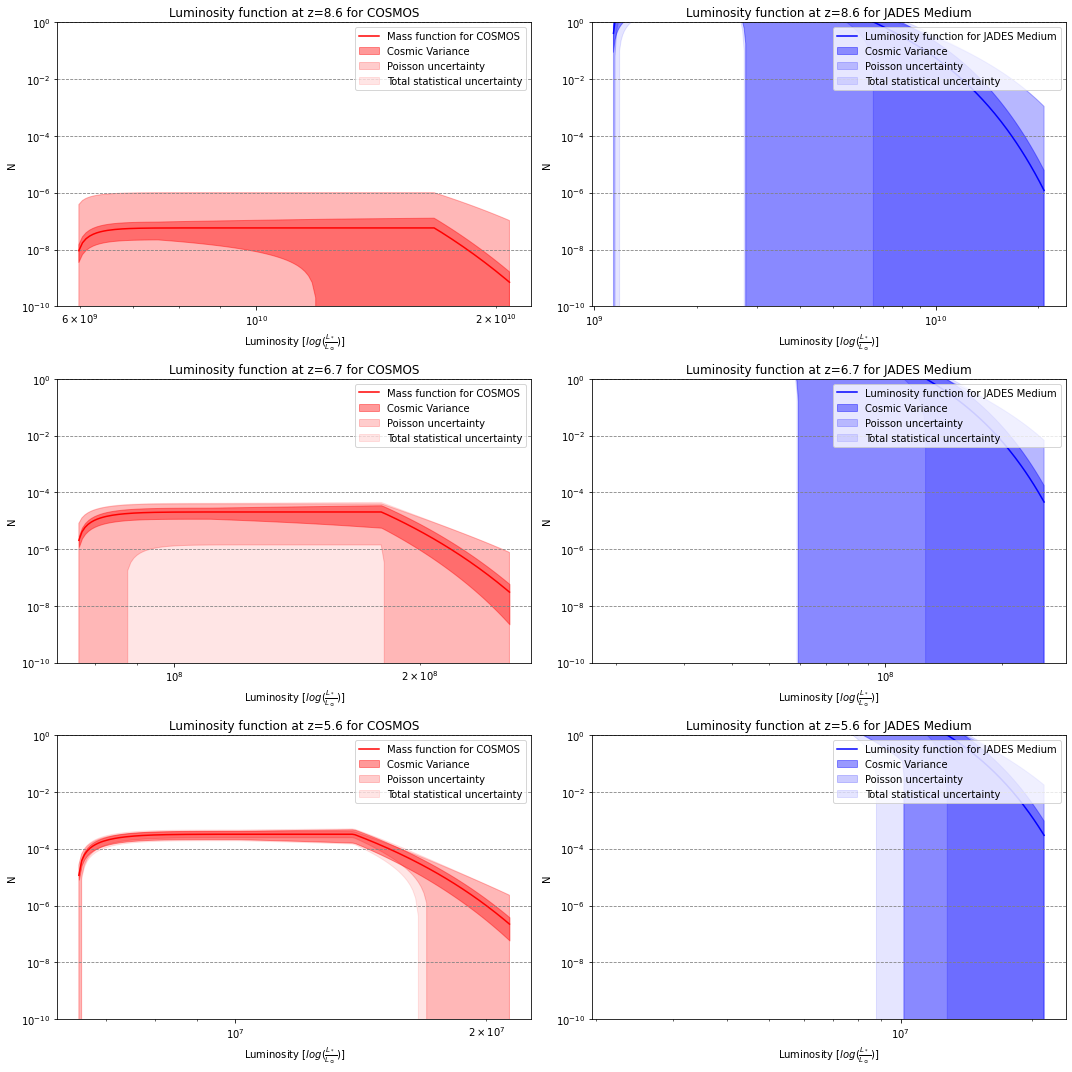

In [21]:
lums, mean = compare_lumfunc('COSMOS', 'JADES Medium', masssurveys, [13,17,20],start=0, stop=-1,save=0, top=1, bottom=1e-10)

In [ ]:
mean

In [ ]:
k1=10
plt.plot(LF_center(masssurveys['COSMOS'][2], z_vals[k1]), masssurveys['COSMOS'][0][k1])
plt.yscale('log')

# Time to plot

In [ ]:
def mass_func_fill(sur, k, mean, sig, ax=None, legend=True, c='r',start=1, norm=150, save=False, i=0, scale='log', top=None, bottom=1e-7):
    mass=masses[start:]
    h=cosmo.H0.value/100
    dz=[z_vals[k+1]-z_vals[k],z_vals[k]-z_vals[k-1]]
    norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*area_dict[sur]
    norm=norm*h**3
    errcv=sig*mean
    errtot=np.sqrt(mean+(errcv)**2)
    poiserr=np.sqrt(mean)
    errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
    if ax==None:
        fig, ax=plt.subplots(figsize=(12,9))
    else:
        s=0
        
    if i==0:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4,
                    label='Poisson uncertainty')
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2,
                    label='Cosmic Variance')
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1,
                    label='Total statistical uncertainty')
    else:
        ax.plot(mass, mean[k][start:], c, label=f'Mass function for {sur}')
        ax.fill_between(mass, mean[k][start:]+poiserr[k][start:],mean[k][start:]-poiserr[k][start:], color = c, alpha=0.4)
        ax.fill_between(mass, mean[k][start:]+errcv[k][start:],mean[k][start:]-errcv[k][start:], color = c, alpha=0.2)
        ax.fill_between(mass, mean[k][start:]+ errtot[k][start:], mean[k][start:]- errtot[k][start:], color =c, alpha=0.1)
    if legend:
        ax.yaxis.grid(color='gray', linestyle='dashed')
        # ax.hlines(1,8,11, 'k', linestyle='dashed')
        ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
               title=f'Mass function at z={np.round(z_vals[k],1)} for different survey designs', yscale=scale)
        ax.set_ylim(bottom, top)
        ax.legend(fontsize=10, loc='upper left')
    if save:
        plt.savefig(f'figs/masslumfunc/z_{np.round(z_vals[k],1)}_total.png')

In [157]:
def lin(z,a=-0.04418885,b=-0.95909967):
    return a*z+b

def uv_lum(m, z1):
    return 2*(lin(z1)-m)

## Plot JADES DEEP + medium


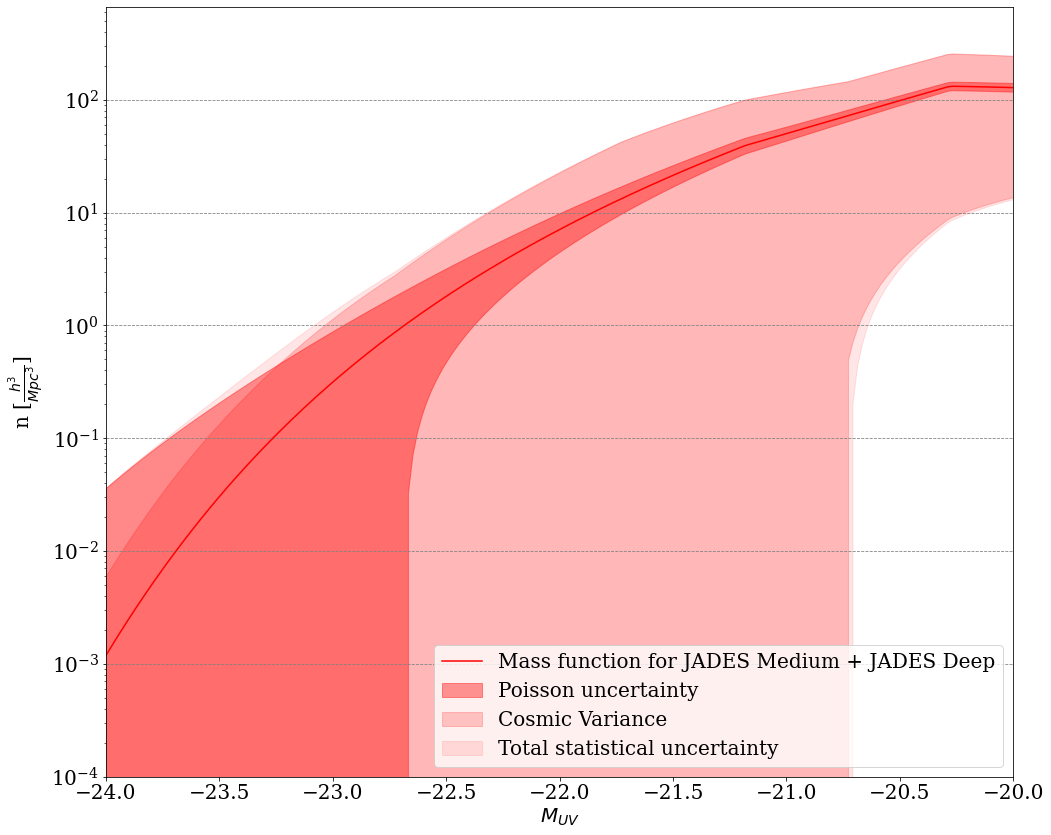

In [173]:
import matplotlib
font = {'family' : 'serif',
        'size'   : 20}

matplotlib.rc('font', **font)

mean1, sig, newmass =masssurveys['JADES Medium']
mean12, sig2, newmass2 = masssurveys['JADES Deep']
mean0 =mean1 + mean12
sur='JADES Medium + JADES Deep'
ks=[12]
fig, ax=plt.subplots(figsize=(15,12), nrows=1)
h=cosmo.H0.value/100
i=0
start, stop, c, scale = 0,-1, 'r', 'log'
top,bottom=None, 1e-4

mass=newmass
mean=mean1
dz=[z_vals[k-1]-z_vals[k],z_vals[k]-z_vals[k+1]]
norm=(cosmo.comoving_volume(z_vals[k]+dz[0]/2)-cosmo.comoving_volume(z_vals[k]-dz[1]/2))*(190+46)/3600/tot_sky
norm=norm*h**3
norm=1
errcv=np.sqrt((sig*mean1)**2+(sig2*mean12)**2)
errtot=np.sqrt(mean+(errcv)**2)
poiserr=np.sqrt(mean)
errcv, errtot, poiserr, mean=errcv/norm, errtot/norm, poiserr/norm, mean/norm
mass=uv_lum(mass, z_vals[k])
rel=errcv[k]**2/poiserr[k]**2
ax.plot(mass[start:stop], mean[k][start:stop], c, label=f'Mass function for {sur}')
ax.fill_between(mass[start:stop], mean[k][start:stop]+poiserr[k][start:stop],mean[k][start:stop]-poiserr[k][start:stop], color = c, alpha=0.4,
            label='Poisson uncertainty')
ax.fill_between(mass[start:stop], mean[k][start:stop]+errcv[k][start:stop],mean[k][start:stop]-errcv[k][start:stop], color = c, alpha=0.2,
            label='Cosmic Variance')
ax.fill_between(mass[start:stop], mean[k][start:stop]+ errtot[k][start:stop], mean[k][start:stop]- errtot[k][start:stop], color =c, alpha=0.1,
            label='Total statistical uncertainty')

ax.yaxis.grid(color='gray', linestyle='dashed')
# ax.hlines(1,8,11, 'k', linestyle='dashed')
# ax.set(xlabel=r'Mass [$log(\frac{M_*}{M_\odot})$]', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]',\
#        title=f'Mass function at z={np.round(z_vals[k],1)} for {sur}', yscale=scale)

ax.set(xlabel=r'$M_{UV}$', ylabel=r'n [$\frac{h^3}{Mpc^3}}$]', yscale=scale)
ax.set_ylim(bottom, top)
ax.set_xlim(-24,-20)
ax.legend(fontsize=20, loc='lower right')

fig.tight_layout()